In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
#os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

In [2]:
## -- FUNCTIONS DEFINITION

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)


In [3]:
# -- Path for netcdf files
out_path = "C:/Users/mastr/Documents/Amazon/RESULTS/validation"      
# -- Create directories
checkDir(out_path)

In [4]:
##### ------- Open data (REANALYSIS) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon/validation/'             
var_name = 'tos'
files = var_name + '_hadsst' + '_1x1_val.nc' 

DS_obs = xr.open_dataarray(os.path.join(data_path+files), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #DS_obs = DS_obs.mean(axis=0)
DS_obs = DS_obs.where(DS_obs != -1000.)  ## Replace -1000 (sea ice) with nan
DS_obs = DS_obs.rename({"longitude":"lon"}); DS_obs = DS_obs.rename({"latitude":"lat"})
#DS_obs = DS_obs.roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
#DS_obs = DS_obs.reindex(lat=DS_obs.lat[::-1])                                   # Invert latitude to -89.5 89.5
DS_obs = DS_obs.assign_coords(lon=(DS_obs.lon - 0.5)); 
#DS_obs = DS_obs.assign_coords(lat=(((DS_obs.latitude * -1) ))); 

##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon/validation/'               ## MAC OS
scenario = 'historical'
files = var_name + '_*_' + scenario + '*_1x1_val.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):               # List of files sorted by name
        content = nc.Dataset(filepath).parent_source_id
        files_list.append(content)   

DS_models = []
for filepath in sorted(glob.glob(os.path.join(data_path+files))):  
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    DS_models.append(content)

for i, item in enumerate(DS_models):
    if DS_models[i].lon[0] == 0.5:
        #DS_models[i] = DS_models[i].roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
        DS_models[i] = DS_models[i].assign_coords(lon=(DS_models[i].lon - 0.5)); 

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\mastr\\Documents\\Amazon\\validation\\tos_hadsst_1x1_val.nc'

## Validation Statistics

In [ ]:
seas = "DJF"

cell_area_obs = cell_weight(DS_obs)
 

## -- REANALYSIS 
## -- Compute multi-yearly mean 
DS_obs_ymean = DS_obs.mean(dim = 'time')

## -- Compute seasonal mean that you choose
DS_obs_seasmean = DS_obs.sel(time = DS_obs.time.dt.season == seas).mean(dim = "time")

## -- Compute multi-year monthly mean 
DS_obs_monmean = DS_obs.groupby('time.month').mean(dim = 'time')

## -- Compute multi-year monthly mean seasonality trend
DS_obs_monfldmean = DS_obs.weighted(cell_area_obs).mean(["lon", "lat"]).groupby('time.month').mean(...)          ## Use .mean(...) as .mean(dim = ["time","lat", "lon"])

In [ ]:
# Biases in ESM  

bias_ymean = [(a.mean(dim = 'time') - DS_obs_ymean).compute() for a in DS_models]
bias_seasmean = [(a.sel(time = DS_models[i].time.dt.season == seas).mean(dim = "time") - DS_obs_seasmean).compute() for a in DS_models]
bias_monmean = [(a.groupby('time.month').mean(dim = 'time') - DS_obs_monmean).compute() for a in DS_models]
bias_seasmean_rel = [a - a.sel(lat = slice(-30,30)).mean(["lon","lat"]) for a in bias_seasmean]

### Plot Models Oceans

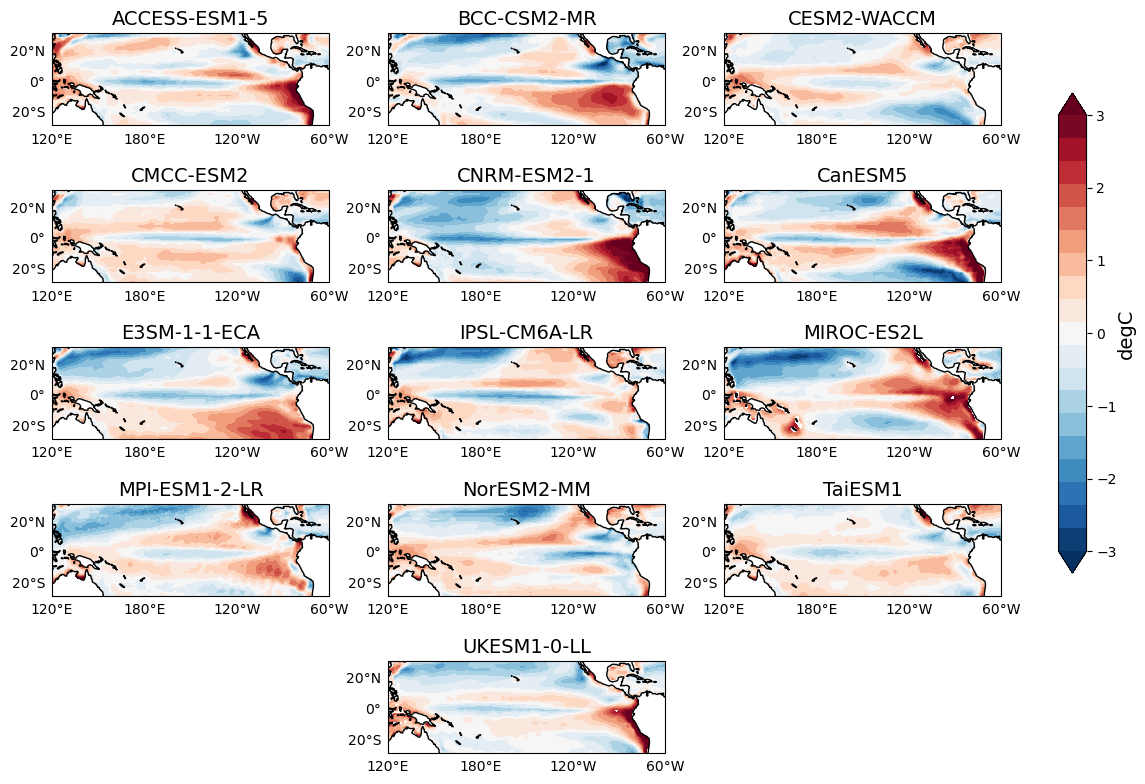

In [ ]:
#### ------- MULTIMODEL PLOT -------- ####

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

data_plot = bias_seasmean_rel

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM

lon_min = 120
lon_max = 300
lat_min = -30 
lat_max = 30

# --- Plot configuration
width_inch = 14
height_inch = 12

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_label = 'degC'                                        # Hydro: 'mm' mrso:'Kgm$^{-2}$' tas&tos:"degC"  Carbon:'gCm$^{-2}$y$^{-1}$'abs 
cbar_position = "top"
cmap = "RdBu_r"                                                       # mrso:"BrBG", pr:"RdBu", tas:"YlOrRd" Carbon:"RdYlGn"abs, ts:"coolwarm"

# --- Title & Axes labels
if var_name == 'tos':
    title = 'Relative SST Tropical Pacific Ocean' + " - " + " 1980/2010 " + seas + " Mean"

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'
#title = ' - '.join((var_str, time_period))

title_fontstyle = {
    "fontsize": "20",
 #   "fontstyle": "italic",
 #   "fontweight": "bold",
    "pad": 30
}

xlabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 30
}

ylabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 20
}

cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

# Create the figure 
#ax = plt.axes(projection=ccrs.PlateCarree())

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(5, 6)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 3:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree(central_longitude=180))
    if ((i > 2) and (i < 6)):
        ax = fig.add_subplot(gs[1, 2 * i - 6 : 2 * i - 4], projection = ccrs.PlateCarree(central_longitude=180))
    if ((i > 5) and (i < 9)):
        ax = fig.add_subplot(gs[2, 2 * i - 12 : 2 * i -10], projection = ccrs.PlateCarree(central_longitude=180))
    if ((i > 8) and (i < 12)):
        ax = fig.add_subplot(gs[3, 2 * i - 18 : 2 * i -16], projection = ccrs.PlateCarree(central_longitude=180))
    if i > 11:
        ax = fig.add_subplot(gs[4, 2 * i - 22 : 2 * i -20], projection = ccrs.PlateCarree(central_longitude=180))

    lons = data_plot[i].lon
    lats = data_plot[i].lat

    min_value, max_value, bins_value = -3, 3, 20
    levels = np.linspace(min_value, max_value, bins_value, endpoint=True)

    map = ax.contourf(lons, lats, data_plot[i], levels ,transform = ccrs.PlateCarree(), cmap=cmap, extend = "both")#, norm=colors.TwoSlopeNorm(0))               ## -- don't use colors.TwoSlopeNorm(0) for tas
    # Alternative plotting
    # map = data_plot[i].plot.pcolormesh(ax = ax, transform=ccrs.PlateCarree(), cmap=cmap,add_colorbar=False, extend = "both"  )           ## -- don't use colors.TwoSlopeNorm(0) for tas

    ax.set_extent([lon_min, lon_max, lat_min+2, lat_max+2], ccrs.PlateCarree())
    ax.coastlines()

    # # Longitude labels
    # ax.set_xticks(np.int64(np.arange(lon_min,lon_max,60)), crs=ccrs.PlateCarree())
    # lon_formatter = LONGITUDE_FORMATTER
    # ax.xaxis.set_major_formatter(lon_formatter)
    # #ax.set_xlabel(xlabel, **xlabel_fontstyle)

    # # Latitude labels
    # ax.set_yticks(np.arange(lat_min,lat_max,20), crs=ccrs.PlateCarree())
    # lat_formatter = LATITUDE_FORMATTER
    # ax.yaxis.set_major_formatter(lat_formatter)
    # #ax.set_ylabel(ylabel, **ylabel_fontstyle)

    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),x_inline=False, y_inline=False,linewidth=0, 
                            xlocs=[120,180,-120, -60],
                            ylocs=[-20,0,20])
    gl.right_labels = False
    gl.top_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # ax.tick_params(axis='both', labelsize=12 ) 
    ax.label_outer()
    ax.set_title(data_plot[i].esm.values,fontsize=14)  

# --- Plot colorbar
fig.subplots_adjust(bottom=0.1, top=0.7, left=0.1, right=0.8, wspace=0.2, hspace=0.7)
# fig.tight_layout()
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.4])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map, cax=cbar_ax, extend="both")

clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(min_value,3.1,0.5))
# clb.ax.locator_params(nbins=20)
clb.set_ticks([-3,-2,-1,0,1,2,3])
clb.cmap.set_over('maroon')
clb.cmap.set_under('darkblue')

# --- Set plot properties
# fig.suptitle(title, fontsize = 20, y=0.75)

# --- Output file
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### Plot Reanalysis Oceans

In [ ]:
#### ------- REANALYSIS PLOT -------- ####
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = DS_obs_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = 0
lon_max = 359
lat_min = -30 
lat_max = 30

# --- Plot configuration
width_inch = 10
height_inch = 6

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_label = 'degC'                                        # Hydro: 'mm' mrso:'Kgm$^{-2}$' tas&tos:"degC"  Carbon:'gCm$^{-2}$y$^{-1}$'abs 
cbar_position = "top"
cmap = "RdBu_r"                                                       # mrso:"BrBG", pr:"RdBu", tas:"YlOrRd" Carbon:"RdYlGn"abs, ts:"coolwarm"

# --- Title & Axes labels
if var_name == 'tos':
    title = 'HadISST, SST Tropical Oceans' + " - " +"1980/2010 " + seas + " Mean"

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'
#title = ' - '.join((var_str, time_period))

title_fontstyle = {
    "fontsize": "20",
 #   "fontstyle": "italic",
 #   "fontweight": "bold",
    "pad": 30
}

xlabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 30
}

ylabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 20
}

cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 5
}

# Create the figure 
#ax = plt.axes(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) #, constrained_layout=True)

lons = data_plot.lon
lats = data_plot.lat

#min_value, max_value = -4, 4           # for Temperature
min_value, max_value = 15, 32        # for ymean
v = np.linspace(min_value, max_value, 40, endpoint=True)

#map = axs.pcolormesh(lons, lats, data_plot, vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap, norm=colors.TwoSlopeNorm(0)) 
map = plt.contourf(lons, lats, data_plot, v, cmap=cmap, transform = ccrs.PlateCarree())#, norm=colors.TwoSlopeNorm(0))             ## -- don't use colors.TwoSlopeNorm(0) for tas


ax.set_extent([lon_min, lon_max, lat_min+2, lat_max], ccrs.PlateCarree())

ax.coastlines()

# # Longitude labels
# ax.set_xticks(np.arange(lon_min,lon_max,60), crs=ccrs.PlateCarree())
# lon_formatter = LONGITUDE_FORMATTER
# ax.xaxis.set_major_formatter(lon_formatter)
# #axs.set_xlabel(xlabel, **xlabel_fontstyle)

# # Latitude labels
# ax.set_yticks(np.arange(lat_min,lat_max+1,10), crs=ccrs.PlateCarree())
# lat_formatter = LATITUDE_FORMATTER
# ax.yaxis.set_major_formatter(lat_formatter)
# #axs.set_ylabel(ylabel, **ylabel_fontstyle)

# ax.tick_params(axis='both', labelsize=12 ) 

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),x_inline=False, y_inline=False,linewidth=0, 
                        xlocs=[60,120,180,-120, -60],
                        ylocs=[-20,0,20])
gl.right_labels = False
gl.top_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#ig.tight_layout()
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.35])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map, cax=cbar_ax, extend="both")

clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(np.arange(15,35,0.5))

# --- Set plot properties
ax.set_title(title, fontsize = 20, y=1.20)
#fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

## ENSO phase locking

In [ ]:
# Mean response of ESM realizations

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new 

In [ ]:
cell_area_obs = cell_weight(DS_obs)

cell_area_models = [cell_weight(a) for a in DS_models]

### Classical Nino3.4

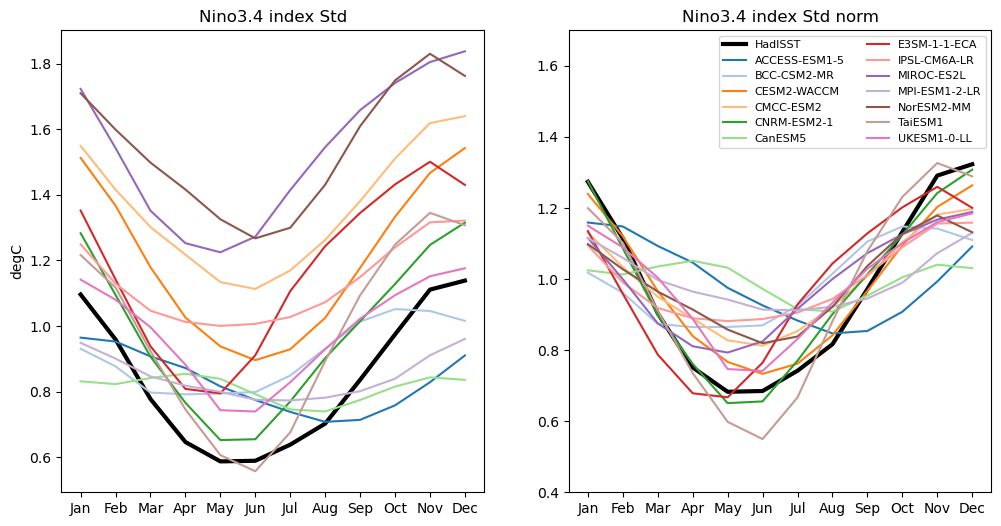

In [ ]:
## ----- Yearly Seasonality in SST in NINO3.4 region ----- ##

data_list = list(np.unique(files_list)); data_list.insert(0,"HadISST")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) #, constrained_layout=True)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

DS_obs_nino34_clim = DS_obs.sel(lat = slice(-5, 5), lon = slice(190, 240), time = slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_obs).mean(["lat", "lon"])
DS_obs_nino34 = (DS_obs.sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_obs[i]).mean(["lat", "lon"]).groupby('time.month') - DS_obs_nino34_clim).rolling(time = 3, center = True).mean()
DS_obs_nino34_norm = (DS_obs_nino34 - DS_obs_nino34.mean())/DS_obs_nino34.std()
DS_obs_nino34 = DS_obs_nino34.groupby('time.month').std(dim = 'time')
DS_obs_nino34_norm = DS_obs_nino34_norm.groupby('time.month').std(dim = 'time')

axs[0].plot(DS_obs_nino34, color = 'black', linewidth = 3)
axs[1].plot(DS_obs_nino34_norm, color = 'black', linewidth = 3)

axs[0].set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
axs[1].set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

# Calculate the seasonality for every realization
nino34 = []
nino34_norm = []
for i, item in enumerate(DS_models):
    clim = item.sel(lat = slice(-5, 5), lon = slice(190, 240), time = slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_models[i]).mean(["lat", "lon"])
    nino = (item.sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_models[i]).mean(["lat", "lon"]).groupby('time.month') - clim).rolling(time = 3, center = True).mean()
    nino_norm = nino/nino.std()
    nino = nino.groupby('time.month').std(dim = 'time')
    nino_norm = nino_norm.groupby('time.month').std(dim = 'time')
    nino34.append(nino)
    nino34_norm.append(nino_norm)

# Mean the response for every ESM
nino34 = xr_mean_list(nino34, files_list)
nino34_norm = xr_mean_list(nino34_norm,files_list)

for i, item in enumerate(nino34):
    axs[0].plot(months, nino34[i])
    axs[1].plot(months, nino34_norm[i])

# axs[0].set_ylim(0.3,1.8)
axs[0].set_ylabel("degC")
axs[0].set_title("Nino3.4 index Std")
axs[1].set_title("Nino3.4 index Std norm")
axs[1].set_ylim(0.4,1.7)
axs[1].legend(data_list, fontsize = 8, ncol=2)

title = "Nino3.4 index phase locking"
# fig.suptitle(title, fontsize = 14)
output_file = os.path.join(out_path + "/validation_" + title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6)) #, constrained_layout=True)

DS_obs_nino34_clim = DS_obs.sel(lat = slice(-5, 5), lon = slice(190, 240), time = slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_obs).mean(["lat", "lon"])
DS_obs_nino34 = (DS_obs.sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_obs[i]).mean(["lat", "lon"]).groupby('time.month') - DS_obs_nino34_clim)
DS_obs_tropoc_mean = DS_obs.sel(lat = slice(-30, 30), time = slice("1981-01", "2010-12")).weighted(cell_area_obs).mean()
DS_obs_nino34_std = DS_obs_nino34.std(dim = 'time')

axs.plot(DS_obs_nino34_std, DS_obs_tropoc_mean, 'X', color = 'black')

for i, item in enumerate(DS_models):
    clim = item["tos"].sel(lat = slice(-5, 5), lon = slice(190, 240), time = slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_models[i]).mean(["lat", "lon"])
    nino34 = item["tos"].sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_models[i]).mean(["lat", "lon"]).groupby('time.month') - clim
    nino34_std = nino34.std(dim = 'time')
    tropoc_mean = item["tos"].sel(lat = slice(-30, 30), time = slice("1981-01", "2010-12")).weighted(cell_area_models[i]).mean()
    axs.plot(nino34_std, tropoc_mean, 'X')

axs.set_xlabel('Nino3.4 std (°C)')
axs.set_ylabel('Trop Oc mean SST (°C)')
axs.legend(esm)

title = "Nino3.4 index amplitude vs TropOc mean state change"
fig.suptitle(title, fontsize = 14)